In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import datetime
import math
from scipy import stats
import seaborn as sns

# Get data

In [2]:
data_path = os.path.join("data", "generated", "films_mining.xlsx")
film_data = pd.read_excel(data_path)
film_data.shape

(15667, 42)

So, what we basically want to do is
<ul>
<li>figuring out what rows and columns we need to keep.</li>
<li>finding and removing outliers</li>
<li>What to do with missing data</li>
<li>modding and/or generating data that could help with classification</li>
</ul>

# getting rid of missing values

## was columns to keep?

<AxesSubplot:>

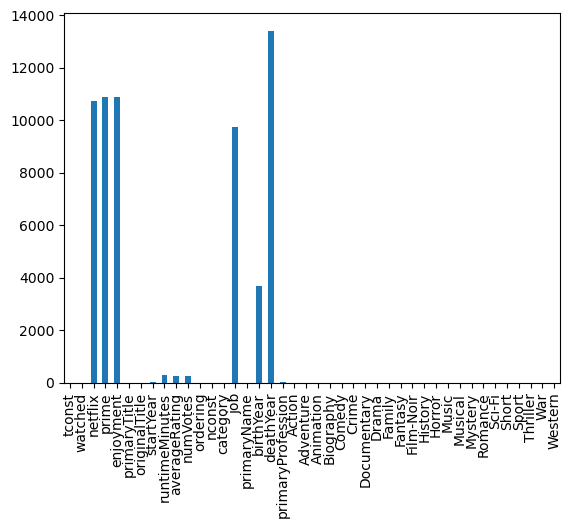

In [3]:
film_data.isna().sum().plot.bar()

netflix and prime need to be filled in more, or must be removed.
They will be removed, because they won't have an effect on finding new movies.
Enjoyment must be filled in more.
missing values in job can be filled with the category values.

primaryTitle, originalTitle, primaryName can be removed, because they don't contain data of statistical usefullness, for me.

BirthYear haw a lot of missing values, not sure what to do with those.
deathyear can be kept. but another column must be made for living status.
we can also make a new column that indicates the age of all personell when the movie came out.

tconst and nconst can be transformed into a numerican id, ore removed


### dropping insignificant columns

In [4]:
film_data.drop(['netflix','prime','primaryTitle','originalTitle','primaryName'],axis=1, inplace=True)

<AxesSubplot:>

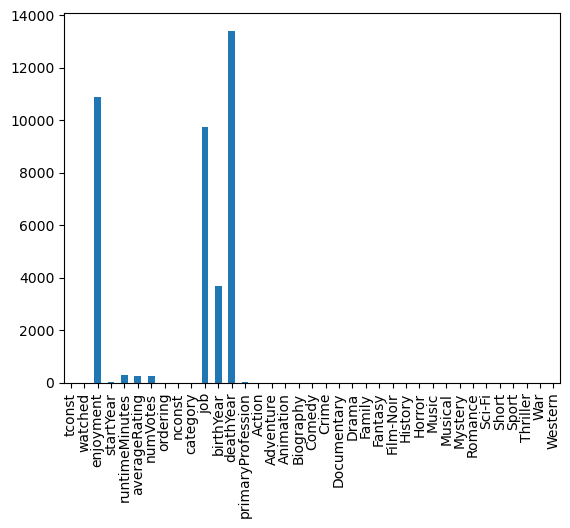

In [5]:
film_data.isna().sum().plot.bar()

### dropping rows that don't have a rating

They are probably not usefull annyway, because enjoyment has a strong correlation with score. So they are not that usefull.

<AxesSubplot:>

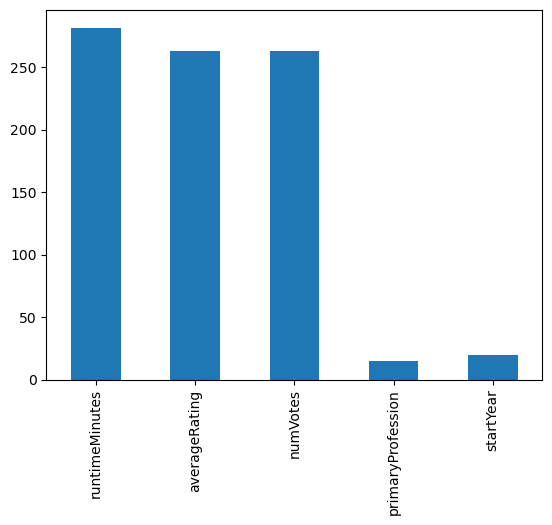

In [6]:
film_data.loc[:,['runtimeMinutes','averageRating','numVotes','primaryProfession', 'startYear']].isna().sum().plot.bar()

remove everything that does not have a average rating or numvotes. we fill the missing runtime minutes with the median.

In [7]:
# remove rows
deleted_rows = film_data.loc[film_data.loc[:,'numVotes'].isna(),:]
film_data = film_data.loc[~film_data.loc[:,'numVotes'].isna(),:]

deleted_rows2 = film_data.loc[film_data.loc[:,'primaryProfession'].isna(),:]
deleted_rows = pd.concat([deleted_rows2,deleted_rows], ignore_index = True)
film_data = film_data.loc[~film_data.loc[:,'primaryProfession'].isna(),:]

deleted_rows2 = film_data.loc[film_data.loc[:,'startYear'].isna(),:]
deleted_rows = pd.concat([deleted_rows2,deleted_rows], ignore_index = True)
film_data = film_data.loc[~film_data.loc[:,'startYear'].isna(),:]

deleted_rows2 = film_data.loc[film_data.loc[:,'averageRating'].isna(),:]
deleted_rows = pd.concat([deleted_rows2,deleted_rows], ignore_index = True)
film_data = film_data.loc[~film_data.loc[:,'averageRating'].isna(),:]

# fill missing runtimeMinutes with median
film_data.loc[film_data.loc[:,'runtimeMinutes'].isna(),'runtimeMinutes'] = film_data.loc[~film_data.loc[:,'runtimeMinutes'].isna(),'runtimeMinutes'].median()

<AxesSubplot:>

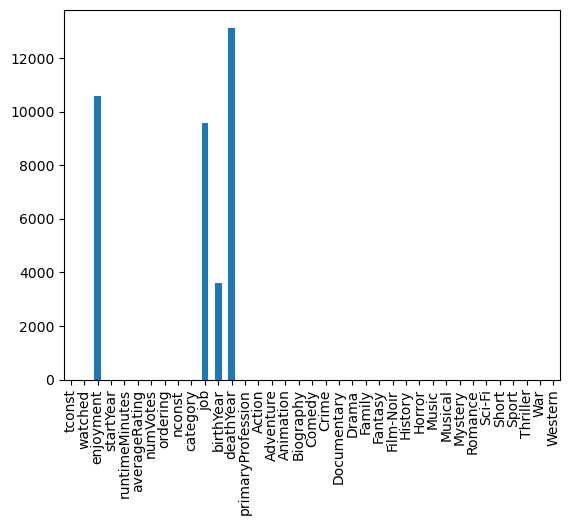

In [8]:
film_data.isna().sum().plot.bar()

# finding and removing outliers

In [9]:
film_data.columns

Index(['tconst', 'watched', 'enjoyment', 'startYear', 'runtimeMinutes',
       'averageRating', 'numVotes', 'ordering', 'nconst', 'category', 'job',
       'birthYear', 'deathYear', 'primaryProfession', 'Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller',
       'War', 'Western'],
      dtype='object')

<ul>
<li>tconst: nothing needed</li>
<li>watched: nothing needed</li>
<li>ordering: nothing needed</li>
<li>nconst: nothing needed</li>
<li>enyoyment: nothing needed</li>

<li>startYear: unique on id and distribution graph</li>
<li>runtimeMinutes: unique on id and distribution graph</li>
<li>averageRating: unique on id and distribution graph</li>
<li>numVotes: : unique on id and distribution graph</li>
<li>birthYear: unique on id and distribution graph</li>
<li>deathYear: unique on id and distribution graph</li>
<li>primaryProfession: unique on id and distribution graph</li>
<li>genres: unique on id and distribution graph</li>

<li>category: unique on id and count graph</li>
<li>job: unique on id and count graph</li>
</ul>

#### startYear: the year doesn't say that much movie enjoyment

<AxesSubplot:xlabel='startYear', ylabel='averageRating'>

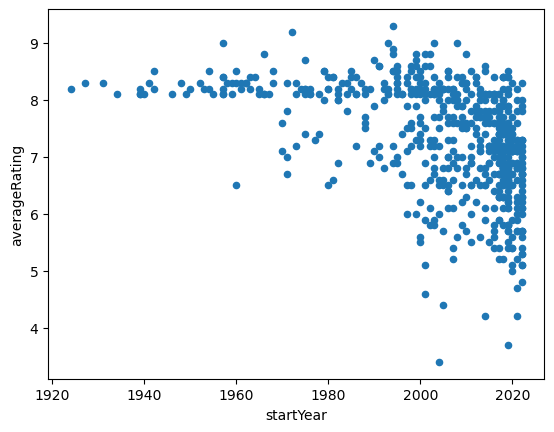

In [10]:
years = film_data.loc[:,['tconst','startYear','averageRating']].drop_duplicates()
years.plot.scatter(x='startYear',y='averageRating')

Maybe remove the earliest 4 years

#### runtimeMinutes: should also not say that much

<AxesSubplot:xlabel='runtimeMinutes', ylabel='averageRating'>

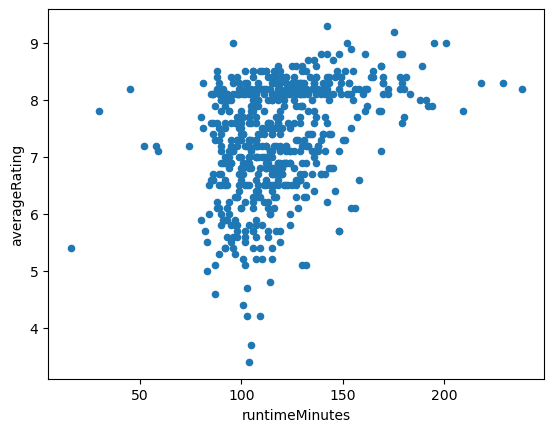

In [11]:
runtimeMinutes = film_data.loc[:,['tconst','runtimeMinutes','averageRating']].drop_duplicates()
runtimeMinutes.plot.scatter(x='runtimeMinutes',y='averageRating')

we could remove the lowest 7 and highest 4

#### average rating: there should be a correaltion with this and enjoyment, so we can keep the whole thing

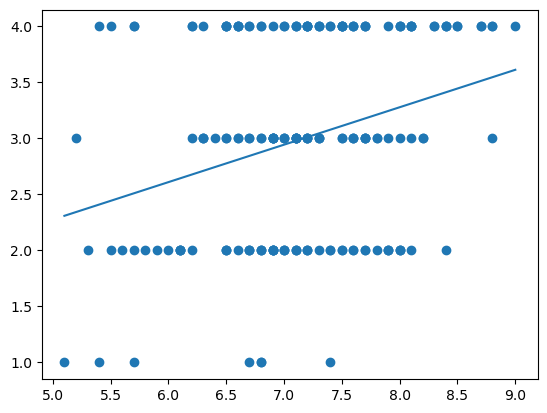

In [12]:
enjoyment_rating = film_data.loc[:,['tconst','enjoyment','averageRating']].drop_duplicates().dropna()
x = enjoyment_rating["averageRating"]
y = enjoyment_rating["enjoyment"]
plt.scatter(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x))
plt.show()

#### numVotes: higher scores correlate with higher number of voters. Must be adjusted

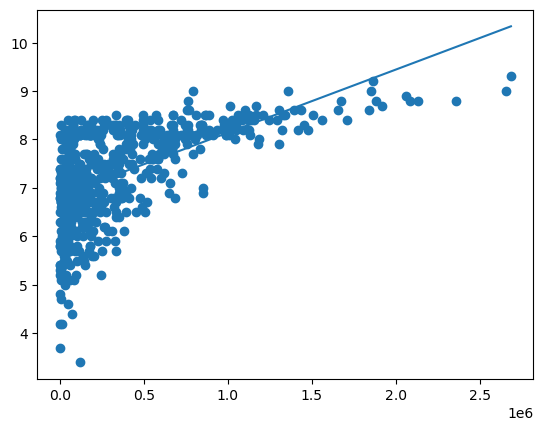

In [13]:
numvotes_rating = film_data.loc[:,['tconst','averageRating', 'numVotes']].drop_duplicates().dropna()
x = numvotes_rating["numVotes"]
y = numvotes_rating["averageRating"]
plt.scatter(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x))
plt.show()

A higher number of votes correlates with a higher score, makes sense. People will rather watch a movie with a high score htan a low score. we must compensate for this.

## Birthyear

<AxesSubplot:xlabel='birthYear', ylabel='averageRating'>

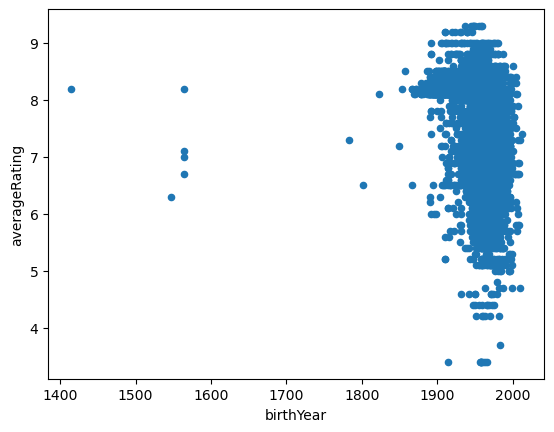

In [14]:
birthyear = film_data.loc[:,['tconst','nconst','birthYear','averageRating']].drop_duplicates()
birthyear.plot.scatter(x='birthYear',y='averageRating')

There are birthyears way before any of my movies were released. Those are mistakes, or vampires, lol. We remove everything that is born 122 years before the startyear. because the oldest person ever was 122 years.

### deathYear

<AxesSubplot:xlabel='deathYear', ylabel='averageRating'>

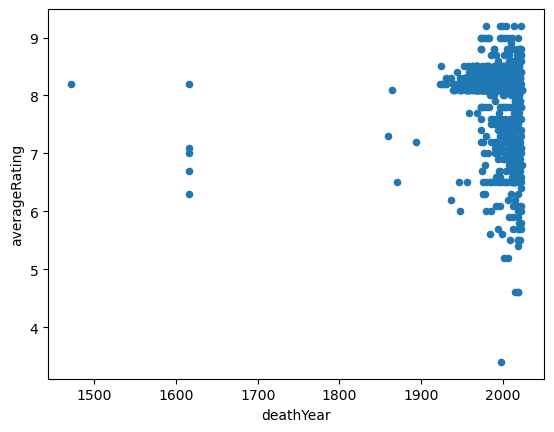

In [15]:
deathyear = film_data.loc[:,['tconst','nconst','deathYear','averageRating']].drop_duplicates()
deathyear.plot.scatter(x='deathYear',y='averageRating')

remove everything before 1905

### primaryProfession

<AxesSubplot:title={'center':'averageRating'}, xlabel='[primaryProfession]'>

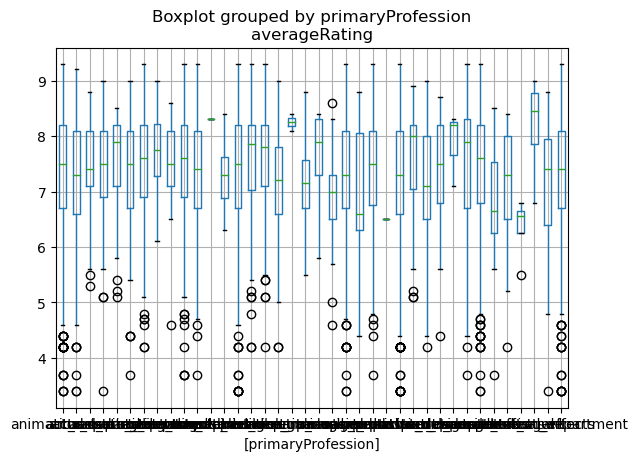

In [16]:
prof = film_data.loc[:,['tconst','nconst','primaryProfession','averageRating']]
prof.boxplot(by='primaryProfession')

there are 4 primaryProfessions with a tiny amount of variability in it. We will remove those rows.

### genres

<AxesSubplot:title={'center':'0'}, xlabel='[level_0]'>

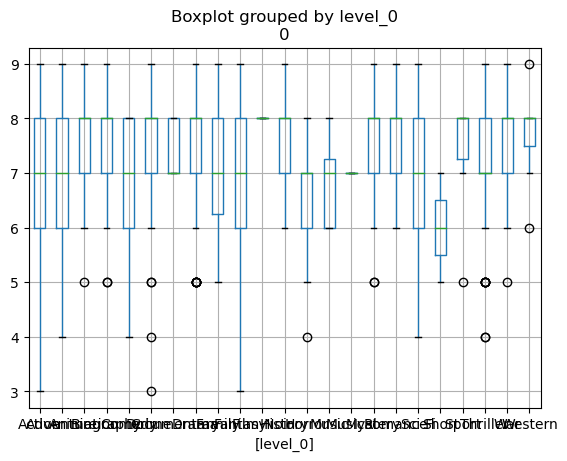

In [17]:
genres = film_data.columns.tolist()[14:]
genres_data = film_data.loc[:,['tconst','averageRating']+genres].drop_duplicates()
genres_data.drop('tconst', axis=1, inplace=True)
genres_data.averageRating = genres_data.averageRating.round(0)
# pd.pivot_table(genres_data, columns='averageRating', aggfunc=np.sum).T
avgrate = genres_data.loc[:,'averageRating']
genres_data = genres_data.drop('averageRating', axis=1)
genres_data_unsta = genres_data.multiply(avgrate, axis='index').unstack().reset_index().drop('level_1', axis=1)
genres_data_unsta.loc[genres_data_unsta.loc[:,0] > 0,:].boxplot(by='level_0')
# i want to repace every 1 with the averageRating and then drop all 0's.

There are two genres which are useless. we can drop those columns.

### Category

<AxesSubplot:title={'center':'averageRating'}, xlabel='[category]'>

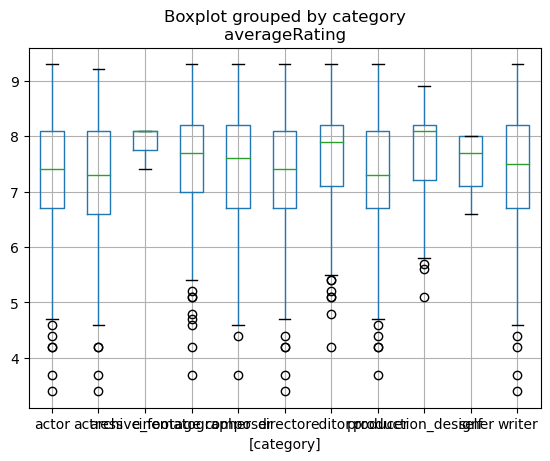

In [18]:
film_data.loc[:,['tconst','averageRating', 'category']].drop_duplicates().drop('tconst', axis=1).boxplot(by='category')

the third and 10'th boxplot don't have much variation. rows with these category values can be removed.

### job, remove imediatly

<AxesSubplot:title={'center':'averageRating'}, xlabel='[job]'>

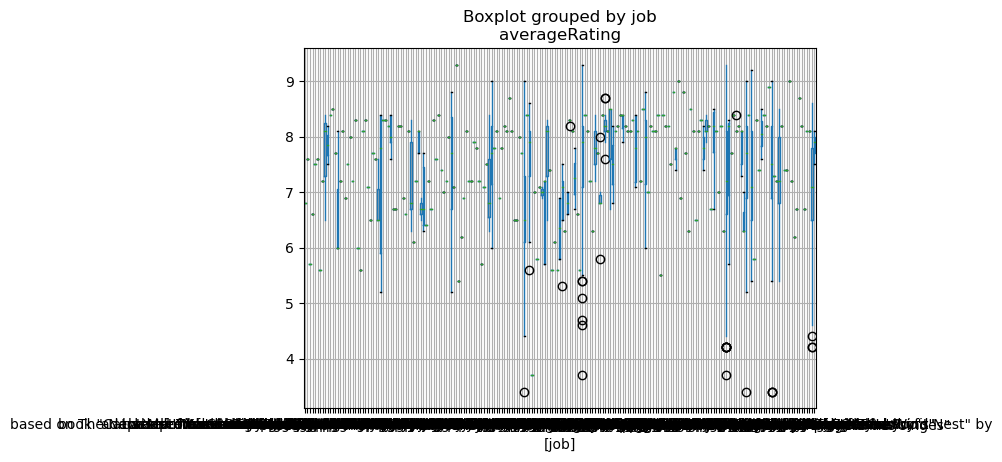

In [19]:
film_data.loc[:,['tconst','nconst','averageRating', 'job']].drop_duplicates().drop('tconst', axis=1).boxplot(by='job')

oh help. lets remove every job that only is encountered once and remake the boxplot.

In [20]:
job_counts = film_data.loc[:,['tconst','nconst','averageRating', 'job']].drop_duplicates().job.value_counts()
job_counts.loc[job_counts > 10]

producer                          922
written by                        190
screenplay                        188
screenplay by                     177
director of photography           156
story                              61
story by                           51
characters                         25
novel                              19
based on the novel by              19
film editor                        17
co-director                        17
based on characters created by     15
based on the book by               13
book                               11
Name: job, dtype: int64

<li>1: Why are there so many producers?</li>
<li>2: where are the actors? > there are a lot of missing values in this column: missing values must be replaced with category</li>
Oke, let's try again

In [21]:
film_data.loc[film_data.loc[:,'job'].isna(),'job'] = film_data.loc[film_data.loc[:,'job'].isna(),'category']
job_counts = film_data.loc[:,['tconst','nconst','averageRating', 'job']].drop_duplicates().job.value_counts()

There are the actors!, oke now
<ul>
<li>we remove everything that is not in this list</li>
<li>remove the word 'by'</li>
</ul>

In [22]:
film_data.loc[:,'job'] = film_data.loc[:,'job'].str.replace(" by", "").replace("based on the ", "").replace("written", "writer").replace("based on the book","book").replace("based on the novel","book").replace('novel','book').replace('film editor', 'editor')
job_counts = film_data.loc[:,['tconst','nconst','averageRating', 'job']].drop_duplicates().job.value_counts()
jobs = job_counts.loc[job_counts > 10].index.tolist()
film_data = film_data.loc[film_data.loc[:,'job'].isin(jobs),:]
film_data

tconst  watched  enjoyment  startYear  runtimeMinutes  \
0      tt0111161     True        NaN     1994.0           142.0   
1      tt0111161     True        NaN     1994.0           142.0   
2      tt0111161     True        NaN     1994.0           142.0   
3      tt0111161     True        NaN     1994.0           142.0   
4      tt0111161     True        NaN     1994.0           142.0   
...          ...      ...        ...        ...             ...   
15398  tt3484204    False        NaN     2019.0           105.0   
15399  tt3484204    False        NaN     2019.0           105.0   
15400  tt3484204    False        NaN     2019.0           105.0   
15401  tt3484204    False        NaN     2019.0           105.0   
15402  tt3484204    False        NaN     2019.0           105.0   

       averageRating   numVotes  ordering     nconst  category  ... Music  \
0                9.3  2686465.0        10  nm0290358    editor  ...     0   
1                9.3  2686465.0        10  nm0290358    editor  ...     0   
2                9.3  2686465.0        10  nm0290358    editor  ...     0   
3                9.3  2686465.0         1  nm0000209     actor  ...     0   
4                9.3  2686465.0         1  nm0000209     actor  ...     0   
...              ...        ...       ...        ...       ...  ...   ...   
15398            3.7      401.0         7  nm1417828  producer  ...     0   
15399            3.7      401.0         7  nm1417828  producer  ...     0   
15400            3.7      401.0         8  nm3792999  composer  ...     0   
15401            3.7      401.0         8  nm3792999  composer  ...     0   
15402            3.7      401.0         8  nm3792999  composer  ...     0   

       Musical  Mystery Romance  Sci-Fi  Short  Sport  Thriller  War  Western  
0            0        0       0       0      0      0         0    0        0  
1            0        0       0       0      0      0         0    0        0  
2            0        0       0       0      0      0         0    0        0  
3            0        0       0       0      0      0         0    0        0  
4            0        0       0       0      0      0         0    0        0  
...        ...      ...     ...     ...    ...    ...       ...  ...      ...  
15398        0        0       0       1      0      0         1    0        0  
15399        0        0       0       1      0      0         1    0        0  
15400        0        0       0       1      0      0         1    0        0  
15401        0        0       0       1      0      0         1    0        0  
15402        0        0       0       1      0      0         1    0        0  

[14646 rows x 37 columns]

<AxesSubplot:>

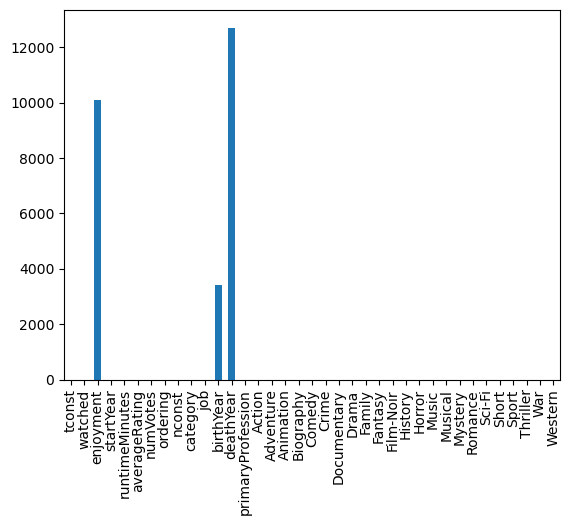

In [23]:
film_data.isna().sum().plot.bar()

## Remove the faulty rows and columns that we identified

### Remove the earliest 4 years

In [24]:
bigger_than = film_data.loc[:,'startYear'].drop_duplicates().sort_values().iloc[5]
film_data = film_data.loc[film_data.loc[:,'startYear'] > bigger_than,:]

### runtimeMinutes

In [25]:
bigger_than = film_data.loc[:,'runtimeMinutes'].drop_duplicates().sort_values().iloc[7]
smaller_than = film_data.loc[:,'runtimeMinutes'].drop_duplicates().sort_values(ascending=False).iloc[4]
film_data =  film_data.loc[film_data.loc[:,'runtimeMinutes'] > bigger_than,:]
film_data =  film_data.loc[film_data.loc[:,'runtimeMinutes'] < smaller_than,:]


<AxesSubplot:xlabel='runtimeMinutes', ylabel='averageRating'>

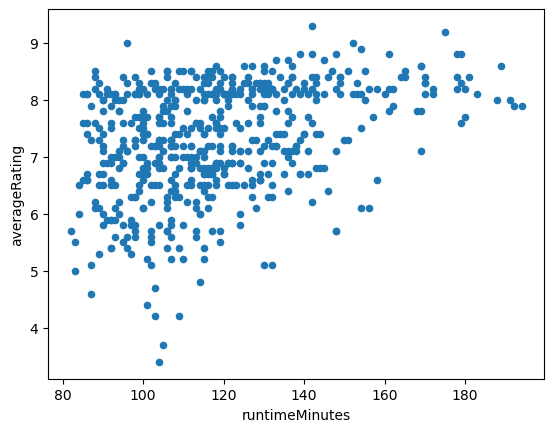

In [26]:
runtimeMinutes = film_data.loc[:,['tconst','runtimeMinutes','averageRating']].drop_duplicates()
runtimeMinutes.plot.scatter(x='runtimeMinutes',y='averageRating')

remove people older than 122 years removed NA's. but lets look at people who have NA as birthyear

In [27]:
film_data.loc[film_data.loc[:,'birthYear'].isna(),'category'].value_counts()

producer               1298
writer                  832
director                242
composer                228
actor                   201
editor                  191
cinematographer         179
actress                  81
production_designer      69
self                      6
Name: category, dtype: int64

### remove people older than 122 years, unless they are NA

<AxesSubplot:xlabel='birthYear', ylabel='averageRating'>

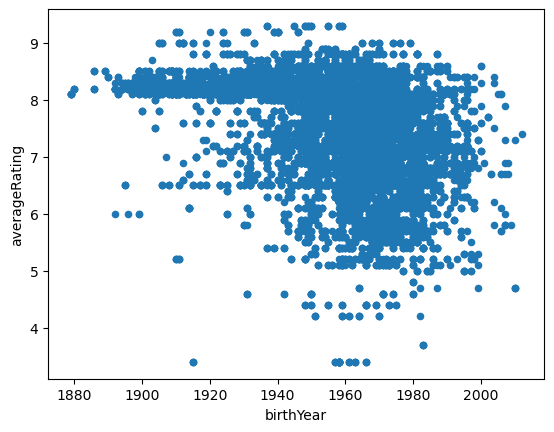

In [28]:
no_birthyear = film_data.loc[film_data.loc[:,'birthYear'].isna(),:]
yes_birthyear = film_data.loc[~film_data.loc[:,'birthYear'].isna(),:]
yes_birthyear = yes_birthyear.loc[(yes_birthyear.loc[:,'startYear'] - yes_birthyear.loc[:,'birthYear']) < 122,:]
film_data = pd.concat([yes_birthyear, no_birthyear], ignore_index=True)
film_data.plot.scatter(x='birthYear',y='averageRating')

In [29]:
film_data.shape

(14147, 37)

<AxesSubplot:>

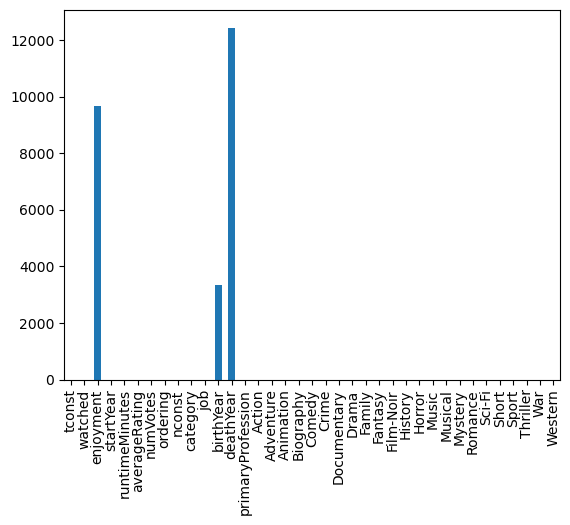

In [30]:
film_data.isna().sum().plot.bar()

### remove everyone with a Deathyear before 1905

<AxesSubplot:xlabel='deathYear', ylabel='averageRating'>

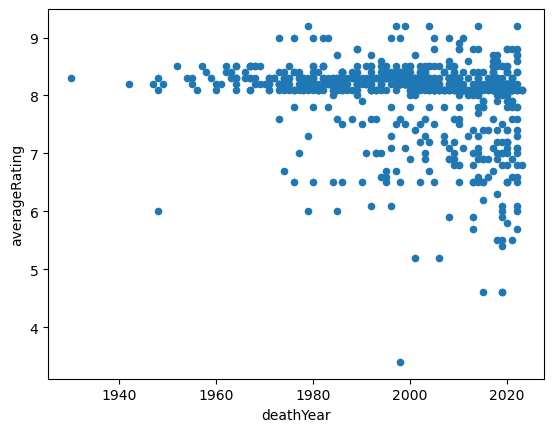

In [31]:
film_data = film_data.loc[(film_data.loc[:,'deathYear'].isna()) | (film_data.loc[:,'deathYear'] > 1905),:]
deathyear = film_data.loc[:,['tconst','nconst','deathYear','averageRating']].drop_duplicates()
deathyear.plot.scatter(x='deathYear',y='averageRating')

### remove the proffessions with a small amount of variability

<AxesSubplot:title={'center':'averageRating'}, xlabel='[primaryProfession]'>

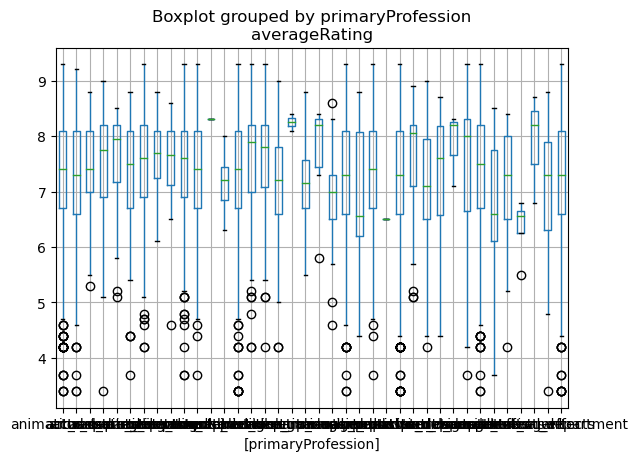

In [32]:
prof = film_data.loc[:,['tconst','nconst','primaryProfession','averageRating']]
prof.boxplot(by='primaryProfession')

In [33]:
test = prof.loc[:,['primaryProfession','averageRating']].groupby("primaryProfession").var().sort_values(by='averageRating')
test = test.unstack().reset_index().drop('level_0',axis=1)
nas = test.loc[:,0].isna()
smallvar = test.loc[:,0] < 0.3
profs_to_keep = test.loc[~(nas | smallvar),'primaryProfession'].tolist()
film_data = film_data.loc[film_data.loc[:,'primaryProfession'].isin(profs_to_keep)]

In [34]:
film_data.shape

(14143, 37)

### Remove genres with small occurance

In [35]:
genres_to_filter = film_data.loc[:,['tconst']+genres].drop_duplicates().drop('tconst', axis=1).sum()
genres_to_drop = genres_to_filter.loc[genres_to_filter < 10].index.to_list()
film_data.drop(genres_to_drop, axis=1, inplace=True)


In [36]:
film_data.shape

(14143, 31)

### Remove categories

<AxesSubplot:title={'center':'averageRating'}, xlabel='[category]'>

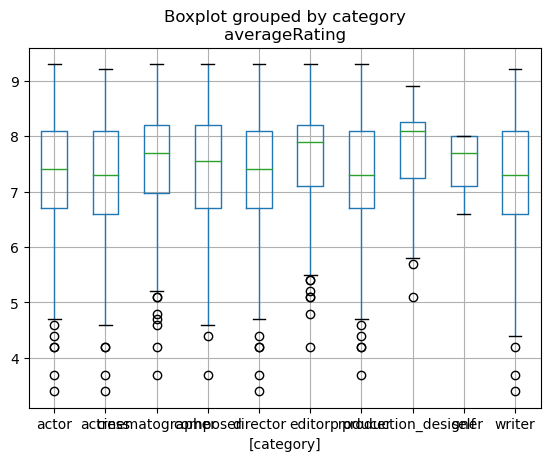

In [37]:
film_data.loc[:,['tconst','averageRating', 'category']].drop_duplicates().drop('tconst', axis=1).boxplot(by='category')

In [38]:
film_data = film_data.loc[film_data.loc[:,'category'] != 'production_designer']

### Look at the numvotes again

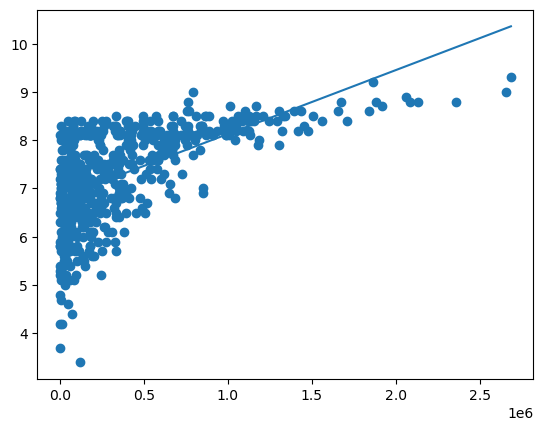

In [39]:
numvotes_rating = film_data.loc[:,['tconst','averageRating', 'numVotes']].drop_duplicates().dropna()
x = numvotes_rating["numVotes"]
y = numvotes_rating["averageRating"]
plt.scatter(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x))
plt.show()

let's see what happens if we take the 10 log

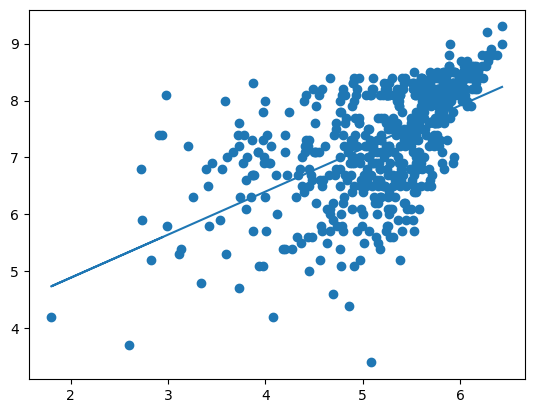

In [40]:
numvotes_rating["numVotes"] = np.log10(numvotes_rating.loc[:,'numVotes'])
x = numvotes_rating["numVotes"]
y = numvotes_rating["averageRating"]
plt.scatter(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x))
plt.show()

that's a lot better, but maybe we can get a better plot with the square root

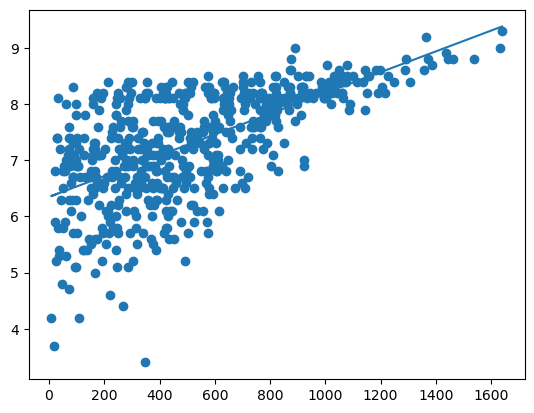

In [41]:
numvotes_rating = film_data.loc[:,['tconst','averageRating', 'numVotes']].drop_duplicates().dropna()
numvotes_rating.loc[:,'numVotes'] = numvotes_rating.loc[:,'numVotes'].transform(np.sqrt)
x = numvotes_rating["numVotes"]
y = numvotes_rating["averageRating"]
plt.scatter(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x))
plt.show()

Let's apply this transformation

In [42]:
film_data.loc[:,'numVotes'] = film_data.loc[:,'numVotes'].transform(np.sqrt)

make 'living status', 'age at release', 'current age' (where death is replaced by age of death)

## generate new data to compensate for missing deathyear

<AxesSubplot:>

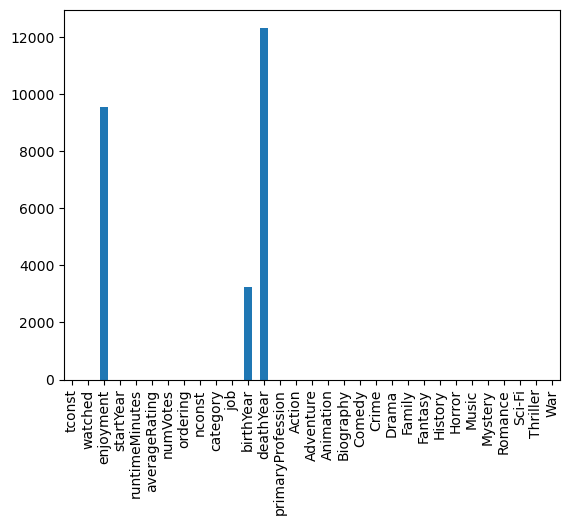

In [43]:
film_data.isna().sum().plot.bar()

transform the information in deathyear to a boolean 'living'

In [44]:
film_data.loc[:,'living'] = film_data.loc[:,'deathYear'].isna()

<b>make new columns: age at release, current age, age at death:</b>
<p>if there is no deathyear, they are still living. We can make new data about the age at release and the current age.</p>

In [45]:
## calculate age at release
is_born =  ~film_data.loc[:,'birthYear'].isna()
film_data.loc[:,'ageAtRelease'] = pd.NA
film_data.loc[is_born,'ageAtRelease'] =  film_data.loc[is_born,'startYear'] - film_data.loc[is_born,'birthYear']

## calculate current age
currentDateTime = datetime.datetime.now()
date = currentDateTime.date()
film_data.loc[:,'currentAge'] = pd.NA
born_and_alive = ~film_data.loc[:,'birthYear'].isna() & film_data.loc[:,'deathYear'].isna()
film_data.loc[born_and_alive,'currentAge'] = date.year - film_data.loc[born_and_alive,'birthYear']

## calculate age at death
film_data.loc[:,"ageAtDeath"] = pd.NA
lived_now_dead = ~film_data.loc[:,'deathYear'].isna() & ~film_data.loc[:,'birthYear'].isna()
film_data.loc[lived_now_dead,"ageAtDeath"] = film_data.loc[lived_now_dead,"deathYear"] - film_data.loc[lived_now_dead,"birthYear"]

<AxesSubplot:>

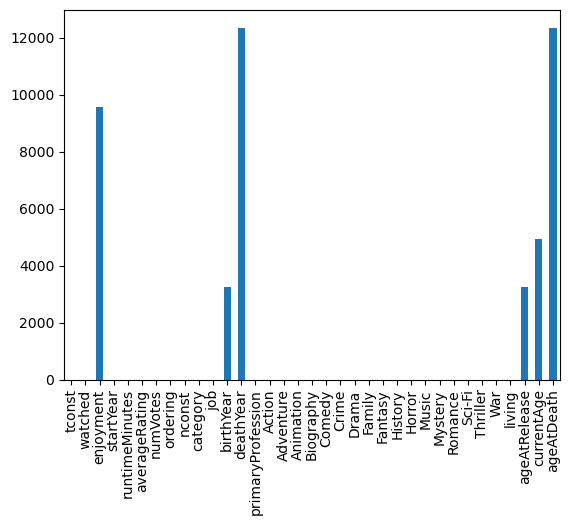

In [46]:
film_data.isna().sum().plot.bar()

<b>estimate missing birthyears:</b>
<p>The problem is that sometimes we don't have a birthyear. but we can calculate the average age of every job at time of release. From there on we can estimate a birthyear for every category bu using this info and the time of release. sometimes the person with missing birthyear occurce multiple times, which is great, because we than can take the average of the aproximated birthyear, coming closer to the real birthyear.</p>

## !! There is a practical error in this. !!
We use job data for my film list, not job data of all people.
On the other hand, the generated data will be massive, but more accurate.
we also don't take the year of release into account.

In [47]:
# flag people with missing birthdays
film_data.loc[:,'estimatedBirthYear'] = film_data.loc[:,'birthYear'].isna()
# get the needed data
data_birthyear_estimate = film_data.loc[:,['nconst','birthYear','ageAtRelease','startYear','job']].dropna().drop_duplicates()
# calculate average ageAtRelease for every job
mean_age_per_job = data_birthyear_estimate.loc[:,['ageAtRelease','job']].groupby('job').mean()
# get the data for every person with a missing birthYear and append ageAtRelease
missing_birthyears = film_data.loc[film_data.loc[:,'birthYear'].isna(),['nconst','job','startYear']].drop_duplicates()
calc_birthYear = pd.merge(missing_birthyears, mean_age_per_job, on="job", how="left")
# calculate the aproximated birthyears, and take the average if a person has gotten two birthYears (side effect: makes the approximation better)
calc_birthYear.loc[:,'birthYear'] = calc_birthYear.loc[:,'startYear'] - calc_birthYear.loc[:,'ageAtRelease']
mean_birthyears_for_missing_birthyears = calc_birthYear.loc[:,['nconst','birthYear']].sort_values('nconst').groupby('nconst').mean().unstack().reset_index().drop('level_0', axis=1)
mean_birthyears_for_missing_birthyears.columns.values[1] = 'birthYear'
# add the birthyears to the people
film_data.loc[:,'birthYear'] = film_data.set_index("nconst").birthYear.fillna(mean_birthyears_for_missing_birthyears.set_index("nconst").birthYear).reset_index().loc[:,'birthYear']
# remove rows that still miss a birthday
film_data = film_data.loc[~film_data.birthYear.isna(),:]
# recalculate age at release
film_data.loc[:,'ageAtRelease'] =  film_data.loc[:,'startYear'] - film_data.loc[:,'birthYear']
## recalculate current age
currentDateTime = datetime.datetime.now()
date = currentDateTime.date()
film_data.loc[:,'currentAge'] = date.year - film_data.loc[:,'birthYear']

<b>estimate missing deathyear</b>
<p>for the people that didn't have a birthyear, we check if they also miss a deathyear.
We calculatre the average age at death for every category.
We calculate the year of death for these.
if the year of death is more than the current year, they are still living.
if they are still living, we erase the year of death.</p>

<AxesSubplot:>

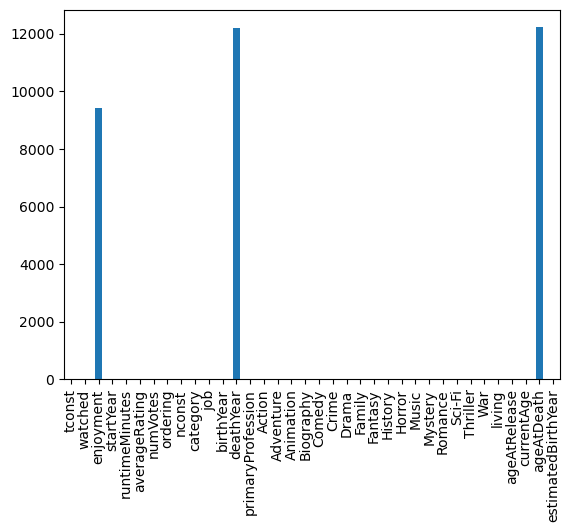

In [48]:
film_data.isna().sum().plot.bar()

i'm kinda curious if there are now people who are older than 122

In [49]:
should_not_be_alive = film_data.loc[:,'living'] & (film_data.loc[:,'birthYear'] < (2023 - 122))
film_data.loc[should_not_be_alive,['startYear','birthYear','deathYear','living','ageAtRelease','currentAge','estimatedBirthYear']]

startYear    birthYear  deathYear  living  ageAtRelease  currentAge  \
498       1960.0  1899.000000        NaN    True     61.000000  124.000000   
1100      1983.0  1896.000000        NaN    True     87.000000  127.000000   
1101      1983.0  1896.000000        NaN    True     87.000000  127.000000   
1102      1983.0  1896.000000        NaN    True     87.000000  127.000000   
1103      1983.0  1894.000000        NaN    True     89.000000  129.000000   
1104      1983.0  1894.000000        NaN    True     89.000000  129.000000   
1105      1983.0  1894.000000        NaN    True     89.000000  129.000000   
1370      2012.0  1894.000000        NaN    True    118.000000  129.000000   
1371      2020.0  1894.000000        NaN    True    126.000000  129.000000   
1372      2020.0  1894.000000        NaN    True    126.000000  129.000000   
1376      2020.0  1892.000000        NaN    True    128.000000  131.000000   
1377      2020.0  1892.000000        NaN    True    128.000000  131.000000   
1870      2019.0  1897.000000        NaN    True    122.000000  126.000000   
1871      2019.0  1897.000000        NaN    True    122.000000  126.000000   
1877      2019.0  1879.000000        NaN    True    140.000000  144.000000   
1878      2019.0  1879.000000        NaN    True    140.000000  144.000000   
1879      2019.0  1879.000000        NaN    True    140.000000  144.000000   
5594      2019.0  1895.000000        NaN    True    124.000000  128.000000   
5595      2019.0  1895.000000        NaN    True    124.000000  128.000000   
5596      2019.0  1895.000000        NaN    True    124.000000  128.000000   
6359      1997.0  1899.000000        NaN    True     98.000000  124.000000   
6360      1997.0  1899.000000        NaN    True     98.000000  124.000000   
6376      1999.0  1896.000000        NaN    True    103.000000  127.000000   
6390      1999.0  1892.000000        NaN    True    107.000000  131.000000   
7031      1991.0  1899.000000        NaN    True     92.000000  124.000000   
7032      1991.0  1899.000000        NaN    True     92.000000  124.000000   
7033      1991.0  1899.000000        NaN    True     92.000000  124.000000   
7041      2001.0  1889.000000        NaN    True    112.000000  134.000000   
7042      2001.0  1889.000000        NaN    True    112.000000  134.000000   
7043      2001.0  1886.000000        NaN    True    115.000000  137.000000   
7044      2001.0  1886.000000        NaN    True    115.000000  137.000000   
7045      2001.0  1886.000000        NaN    True    115.000000  137.000000   
7208      2014.0  1890.000000        NaN    True    124.000000  133.000000   
7209      2014.0  1890.000000        NaN    True    124.000000  133.000000   
7210      2014.0  1890.000000        NaN    True    124.000000  133.000000   
7211      2014.0  1899.000000        NaN    True    115.000000  124.000000   
7371      2018.0  1900.000000        NaN    True    118.000000  123.000000   
7372      2018.0  1900.000000        NaN    True    118.000000  123.000000   
7373      2018.0  1900.000000        NaN    True    118.000000  123.000000   
7377      2018.0  1895.000000        NaN    True    123.000000  128.000000   
7389      2018.0  1892.000000        NaN    True    126.000000  131.000000   
7623      2001.0  1892.000000        NaN    True    109.000000  131.000000   
7624      2001.0  1892.000000        NaN    True    109.000000  131.000000   
7625      2001.0  1892.000000        NaN    True    109.000000  131.000000   
7633      2001.0  1899.000000        NaN    True    102.000000  124.000000   
8015      2007.0  1893.000000        NaN    True    114.000000  130.000000   
8016      2007.0  1893.000000        NaN    True    114.000000  130.000000   
8017      2007.0  1893.000000        NaN    True    114.000000  130.000000   
8020      2007.0  1899.000000        NaN    True    108.000000  124.000000   
8021      2007.0  1899.000000        NaN    True    108.000000  124.000000   
8022      2007.0  1899.000000

funny enough, only 1 of the rows is estimated by me. The people should have died by now, but they forgot to add the deathdate. i will just remove these rows.

In [50]:
film_data = film_data.loc[~should_not_be_alive,:]

<AxesSubplot:>

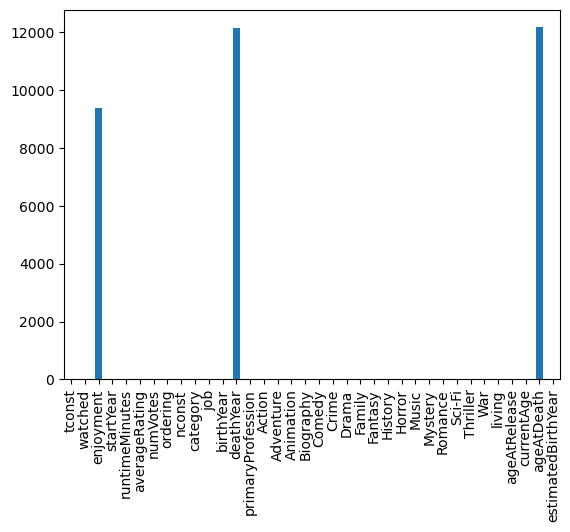

In [51]:
film_data.isna().sum().plot.bar()

let's replace the current age of people who died with their ageAtDeath. Then we can remove ageAtDeath and deathYear.

<AxesSubplot:>

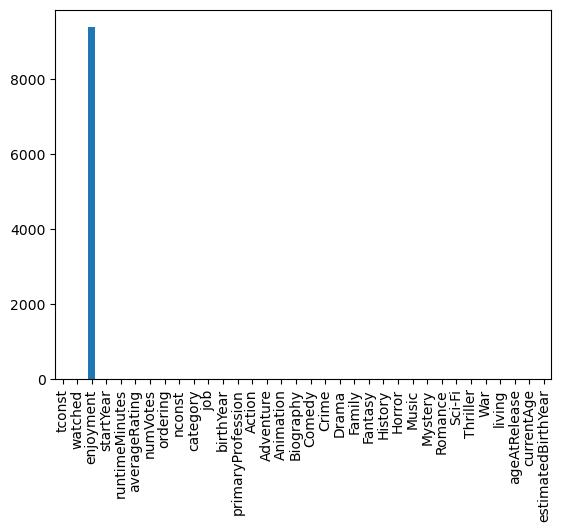

In [52]:
known_dead = ~film_data.loc[:,'ageAtDeath'].isna()
film_data.loc[known_dead,'currentAge'] = film_data.loc[known_dead,'ageAtDeath']
film_data.drop(['ageAtDeath','deathYear'], axis=1, inplace=True)
film_data.isna().sum().plot.bar()

# analysis of variables

for now we use the averageRating as the y_train and remove enjoyment

In [53]:
y_train = film_data.loc[:,'averageRating']
x_train = film_data.drop(['averageRating','tconst','enjoyment'], axis=1).loc[:,['ageAtRelease','currentAge','living']]

In [54]:
sns.pairplot(film_data)


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


variables with not much interaction with averageRating:

    1   watched:        not much interaction with others : delete, as expected

    5   averageRating:  interaction with 2 3 4 6 11 12 13 14 16 17 18 19 20 21 22 24 25 26 : keep

    7   ordering:       interaction with birthyear: if birthyear can replace ordering, remove ordering

    9   action:         interactie with startyear: we remove this one, there is interaction but only with startyear

    10  adventure:      a bit of interaction with startyear, but not much : can be deleted

    13  comedy:         interactie met startYear en runtimeminutes: can be deleted

    23  sci-fi:         interactie met startYear, runtimeminutes, birthyear: keep

    24  thriller:       interactie met runtimeminutes averagerating en numvotes: keep

    remove action, adventure, comedy (makes sence, they are abundant in a lot of movies)
    delete watched later
    if ordering is due to birthyear: remove ordering

https://www.quora.com/How-does-the-order-for-listing-the-acting-cast-work-in-movie-credits?share=1<br>

Ordering determinds importantness in movies. 1 important, 1000 not important<br>

So we only remove action adventure comedy

In [55]:
film_data.drop(['Action','Adventure', 'Comedy'], axis=1, inplace=True)

# The dataset is done

The learning data is almost ready for ML.
I think scikitlearn can make columns categorical instead of strings or integers.
We deal with that during ML.<br><br>
We also have to make the dataset that we will use for discovering new movies.


In [57]:
film_data.sort_values(by=['tconst', 'nconst'], ascending=False).to_excel("data/generated/films_model_making.xlsx",index=False)

# idee voor de acteur dataset: verwijder acteurs waarvan je al bijna zeker weet dat ze niet boeien
# ook de film dataset filteren op alleen films (en korte films)